# Decompiled GNN Pipeline\n
\n
End-to-end modular workflow: dataset stream -> optional compile/decompile -> AST graphs -> embeddings -> GNN training -> metrics/plots.

In [1]:
from pathlib import Path

from config import load_config
from orchestrator import PipelineOrchestrator
from program_store import ProgramStore
from ast_graph import ASTGraphBuilder
from model import ProgramCloneModel
from stream_factory import create_dataset_stream
from training import (
    collect_valid_pairs,
    cosine_eval_pairs,
    evaluate_pairs,
    mc_dropout_eval,
    train_loop,
)
from plotting import plot_final_metrics, plot_loss_over_steps, plot_metric_trends


/Users/jonas/Documents/Bachelor/code-model-embeddings/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg_path = Path("config.default.json").resolve()
cfg = load_config(cfg_path)
cfg

PipelineConfig(general=GeneralConfig(seed=42, device='cpu'), dataset=DatasetConfig(dataset_kind='custom', dataset_root=PosixPath('/Users/jonas/Documents/Bachelor/code-model-embeddings/data/code-clone-dataset/dataset'), clone_types=['type-3', 'type-4'], anchor_filename='main.java', train_size=0.7, val_size=0.15, test_size=0.15, limit_indices=None, negative_pool='same_clone_type', positive_ratio=0.5, bigclonebench_root=PosixPath('/Users/jonas/datasets/bigclonebench'), bigclonebench_labels_path=PosixPath('/Users/jonas/datasets/bigclonebench/clone_labels_typed.txt'), bigclonebench_db_path=PosixPath('/Users/jonas/datasets/bigclonebench/bigclonebenchdb/bcb.h2.db'), bigclonebench_h2_jar=PosixPath('/Users/jonas/datasets/bigclonebench/libs/h2-1.3.176.jar'), bigclonebench_source_root=PosixPath('/Users/jonas/datasets/bigclonebench/ijadataset/bcb_reduced'), bigclonebench_limit_pairs=200000, bigclonebench_db_batch_size=500), compilation=CompilationConfig(enabled=True, java_home=None, vineflower_jar

In [3]:
# Dataset selection:
# cfg.dataset.dataset_kind = "custom"
cfg.dataset.dataset_kind = "bigclonebench"
# For BigCloneBench, choose clone families like WT3_T4 / MT3 / ST3 / VST3:
cfg.dataset.clone_types = ["ST3", "MT3", "WT3_T4"]
cfg.dataset.bigclonebench_limit_pairs = 100000
cfg.dataset.bigclonebench_source_root = Path("~/datasets/bigclonebench/ijadataset/dataset").expanduser().resolve()
cfg.compilation.enabled = False  # recommended for BigCloneBench fragments

# Early stopping defaults (configurable):
cfg.training.early_stopping_enabled = True
cfg.training.early_stopping_metric = "f1"
cfg.training.early_stopping_patience_steps = 200
cfg.training.early_stopping_min_delta = 0.005

stream = create_dataset_stream(cfg)
print("Dataset kind:", cfg.dataset.dataset_kind)
print("Clone types filter:", cfg.dataset.clone_types)
print("Split sizes:", stream.split_summary())
print("Early stopping:", {
    "enabled": cfg.training.early_stopping_enabled,
    "metric": cfg.training.early_stopping_metric,
    "patience_steps": cfg.training.early_stopping_patience_steps,
    "min_delta": cfg.training.early_stopping_min_delta,
})
try:
    print("Train sample:", stream.sample_one("train"))
except Exception as exc:
    print("Train sample unavailable:", exc)


Dataset kind: bigclonebench
Clone types filter: ['ST3', 'MT3', 'WT3_T4']
Split sizes: {'train': 70000, 'val': 15000, 'test': 15000}
Early stopping: {'enabled': True, 'metric': 'f1', 'patience_steps': 200, 'min_delta': 0.005}
Train sample: ('/Users/jonas/Documents/Bachelor/code-model-embeddings/decompiled_gnn/cache/bigclonebench/fragments/3867253.java', '/Users/jonas/Documents/Bachelor/code-model-embeddings/decompiled_gnn/cache/bigclonebench/fragments/6596328.java', 0)


In [4]:
orchestrator = PipelineOrchestrator(cfg)
program_index_payload = orchestrator.prepare_from_dataset(stream)
print("Programs cached:", len(program_index_payload["items"]))
print("Failures:", len(program_index_payload["failures"]))
cfg.cache.program_index_path

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 2327.54it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.decoder.bias            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training 

Programs cached: 7300
Failures: 0


PosixPath('/Users/jonas/Documents/Bachelor/code-model-embeddings/decompiled_gnn/cache/program_index.json')

In [5]:
store = ProgramStore(cfg.cache.program_index_path)
edge_type_to_id = ASTGraphBuilder.edge_type_to_id(cfg.ast.enabled_edge_types)
num_edge_types = len(edge_type_to_id)

model = ProgramCloneModel(
    in_dim=cfg.model.in_dim,
    hidden_dim=cfg.model.hidden_dim,
    num_layers=cfg.model.num_layers,
    num_edge_types=num_edge_types,
    edge_type_dim=cfg.model.edge_type_dim,
    dropout=cfg.model.dropout,
)

train_iter = stream.stream("train", infinite=True)
val_iter = stream.stream("val", infinite=True)
test_iter = stream.stream("test", infinite=True)

In [6]:
model, history = train_loop(
    model=model,
    store=store,
    train_iter=train_iter,
    val_iter=val_iter,
    device=cfg.general.device,
    model_cfg=cfg.model,
    train_cfg=cfg.training,
    seed=cfg.general.seed,
)
history[-1] if history else {}

Training(decompiled_gnn):   0%|          | 0/2000 [00:00<?, ?it/s]

Training(decompiled_gnn):   2%|▎         | 50/2000 [00:19<11:51,  2.74it/s]

step=50 train_loss=0.7949 ema=0.7535 lr=0.001000


Training(decompiled_gnn):   5%|▌         | 100/2000 [00:39<14:08,  2.24it/s]

step=100 train_loss=0.6981 ema=0.7115 lr=0.001000


Training(decompiled_gnn):   8%|▊         | 150/2000 [00:59<12:26,  2.48it/s]

step=150 train_loss=0.7026 ema=0.7077 lr=0.001000


Training(decompiled_gnn):  10%|▉         | 199/2000 [01:19<11:29,  2.61it/s]

step=200 train_loss=0.7265 ema=0.6945 lr=0.001000


Training(decompiled_gnn):  10%|█         | 200/2000 [01:22<41:48,  1.39s/it]

[EARLY_STOP] improved f1 to 0.6496 at step=200
[VAL] step=200 used=200 loss=0.6606 auc=0.7493 acc=0.5200 f1=0.6496 recall=0.8900


Training(decompiled_gnn):  12%|█▎        | 250/2000 [01:42<10:47,  2.70it/s]

step=250 train_loss=0.6279 ema=0.5517 lr=0.001000


Training(decompiled_gnn):  15%|█▌        | 300/2000 [02:01<11:12,  2.53it/s]

step=300 train_loss=0.3814 ema=0.4487 lr=0.001000


Training(decompiled_gnn):  18%|█▊        | 350/2000 [02:21<10:05,  2.72it/s]

step=350 train_loss=0.3428 ema=0.3588 lr=0.001000


Training(decompiled_gnn):  20%|█▉        | 399/2000 [02:40<10:02,  2.66it/s]

step=400 train_loss=0.4375 ema=0.2872 lr=0.001000


Training(decompiled_gnn):  20%|██        | 400/2000 [02:43<36:30,  1.37s/it]

[EARLY_STOP] improved f1 to 0.9032 at step=400
[VAL] step=400 used=200 loss=0.2344 auc=0.9705 acc=0.9100 f1=0.9032 recall=0.8842


Training(decompiled_gnn):  22%|██▎       | 450/2000 [03:04<11:04,  2.33it/s]

step=450 train_loss=0.4840 ema=0.2959 lr=0.001000


Training(decompiled_gnn):  25%|██▌       | 500/2000 [03:24<10:04,  2.48it/s]

step=500 train_loss=0.2656 ema=0.2494 lr=0.001000


Training(decompiled_gnn):  28%|██▊       | 550/2000 [03:43<09:05,  2.66it/s]

step=550 train_loss=0.1693 ema=0.2226 lr=0.001000


Training(decompiled_gnn):  30%|██▉       | 599/2000 [04:02<08:53,  2.63it/s]

step=600 train_loss=0.2268 ema=0.2207 lr=0.001000


Training(decompiled_gnn):  30%|███       | 600/2000 [04:06<29:27,  1.26s/it]

[EARLY_STOP] improved f1 to 0.9395 at step=600
[VAL] step=600 used=200 loss=0.2001 auc=0.9767 acc=0.9350 f1=0.9395 recall=0.9099


Training(decompiled_gnn):  32%|███▎      | 650/2000 [04:26<08:40,  2.59it/s]

step=650 train_loss=0.0382 ema=0.1613 lr=0.001000


Training(decompiled_gnn):  35%|███▌      | 700/2000 [04:46<08:08,  2.66it/s]

step=700 train_loss=0.1771 ema=0.1767 lr=0.001000


Training(decompiled_gnn):  38%|███▊      | 750/2000 [05:06<08:33,  2.44it/s]

step=750 train_loss=0.0733 ema=0.1300 lr=0.001000


Training(decompiled_gnn):  40%|███▉      | 799/2000 [05:25<07:39,  2.61it/s]

step=800 train_loss=0.1443 ema=0.1277 lr=0.001000


Training(decompiled_gnn):  40%|███▉      | 799/2000 [05:29<08:14,  2.43it/s]

[VAL] step=800 used=200 loss=0.1457 auc=0.9878 acc=0.9300 f1=0.9293 recall=0.8762
[EARLY_STOP] stopping at step=800 (no f1 improvement > 0.005 for 200 steps)
[EARLY_STOP] restored best weights from step=600 with f1=0.9395


{'step': 800.0,
 'train_loss': 0.14432010054588318,
 'ema_loss': 0.127662901429486,
 'loss': 0.14570552110671997,
 'used': 200.0,
 'pos': 105.0,
 'neg': 95.0,
 'auc': 0.9877694235588972,
 'accuracy': 0.93,
 'precision': 0.989247311827957,
 'recall': 0.8761904761904762,
 'f1': 0.9292929292929293,
 'threshold': 0.5,
 'best_f1': 0.9423076923076923,
 'best_f1_threshold': 0.35000000000000003,
 'best_precision': 0.9514563106796117,
 'best_recall': 0.9333333333333333,
 'best_accuracy': 0.94,
 'lr': 0.001,
 'es_metric_value': 0.9292929292929293,
 'es_best_metric_value': 0.9395348837209302,
 'es_best_metric_step': 600.0,
 'es_steps_since_improvement': 200.0,
 'es_improved': 0.0,
 'es_triggered': 1.0}

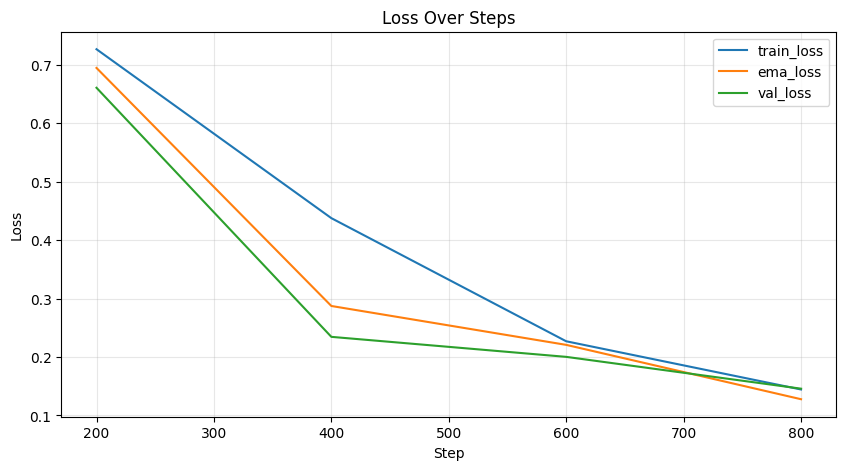

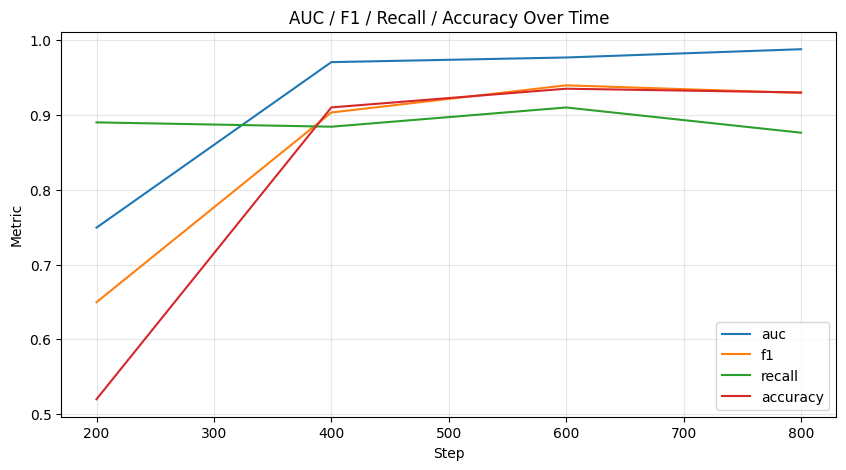

In [7]:
plot_loss_over_steps(history)
plot_metric_trends(history)

In [8]:
test_pairs = collect_valid_pairs(test_iter, store, target_pairs=cfg.training.test_pairs)
test_metrics = evaluate_pairs(
    model=model,
    store=store,
    pairs=test_pairs,
    device=cfg.general.device,
    model_cfg=cfg.model,
)
cosine_metrics = cosine_eval_pairs(
    model=model,
    store=store,
    pairs=test_pairs,
    device=cfg.general.device,
    threshold=0.0,
)
uncertainty = mc_dropout_eval(
    model=model,
    store=store,
    pairs=test_pairs,
    device=cfg.general.device,
    model_cfg=cfg.model,
    uncertainty_cfg=cfg.uncertainty,
)

print("Test metrics (classifier):", test_metrics)
print("Test metrics (cosine):", cosine_metrics)
print("Uncertainty summary:", uncertainty)

Test metrics (classifier): {'loss': 0.15981553494930267, 'used': 1000, 'pos': 490, 'neg': 510, 'auc': 0.9843177270908363, 'accuracy': 0.936, 'precision': 0.9474789915966386, 'recall': 0.9204081632653062, 'f1': 0.9337474120082816, 'threshold': 0.5, 'best_f1': 0.9414225941422594, 'best_f1_threshold': 0.5650000000000001, 'best_precision': 0.9656652360515021, 'best_recall': 0.9183673469387755, 'best_accuracy': 0.944}
Test metrics (cosine): {'used': 1000.0, 'pos': 490.0, 'neg': 510.0, 'auc': 0.9599119647859143, 'accuracy': 0.711, 'precision': 0.6290115532734275, 'recall': 1.0, 'f1': 0.7722616233254531, 'threshold': 0.5, 'best_f1': 0.8752327746741154, 'best_f1_threshold': 0.78, 'best_precision': 0.8047945205479452, 'best_recall': 0.9591836734693877, 'best_accuracy': 0.866}
Uncertainty summary: {'mean_pred_std': 0.016882434487342834, 'median_pred_std': 0.008804617449641228, 'mean_entropy': 0.16218994557857513, 'max_pred_std': 0.2397356778383255}


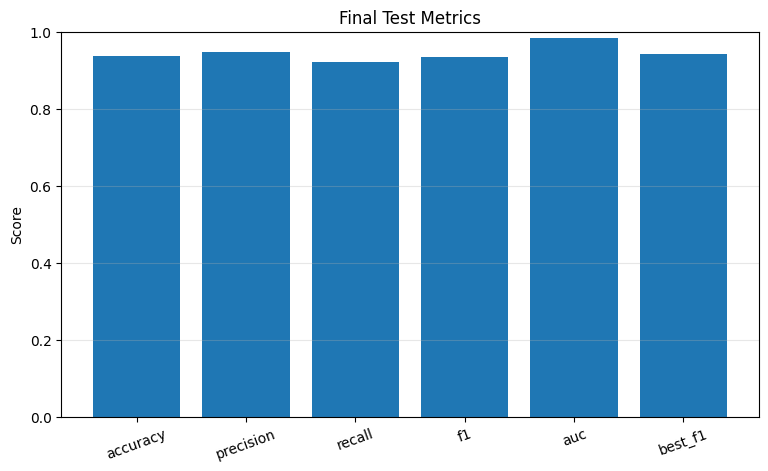

In [9]:
plot_final_metrics(test_metrics)